In [1]:
from datetime import date

import nltk
import numpy as np
import pandas as pd  # For data manipulation and creating DataFrames
import requests  # For making HTTP requests to the API
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
from collections import Counter

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords as STOPWORDS
from nltk.tokenize import word_tokenize
from os import path
from PIL import Image
from wordcloud import WordCloud
from dotenv import load_dotenv
import os

# Define the stopwords for text processing
stopwords = set(STOPWORDS.words('english'))  # Load the English stopwords from NLTK
stopwords.update(['across', 'help', 'skills', 'will'])  # Add custom stopwords

load_dotenv(dotenv_path=os.path.join('.venv', '.env'))
JOOBLE_API_KEY = os.getenv('JOOBLE_API_KEY')

def fetch_jobs_from_api(sites):
    """
    Fetches job listings from the APIs of the specified sites.

    Args:
        sites (list): A list of site names to fetch jobs from. Valid options are 'remoteok' and 'jobicy'.

    Returns:
        A dataframe of job listings if successful, None otherwise.
    """
    api_urls = {
        "remoteok": "https://remoteok.com/api",
        'jobicy': "https://jobicy.com/api/v2/remote-jobs",
        'jooble': "https://jooble.org/api/",
    }
    keywords = ['analy', 'data', 'machine learning', 'intelligence']
    df_columns = [
        'id', 'url', 'company', 'position', 'description', 'location', 'pubDate', 'salaryMin', 'salaryMax',
        'industry', 'jobType', 'jobLevel', 'tags', 'currency', 'salaryPeriod', 'source'
    ]
    job_list = pd.DataFrame(columns=df_columns)  # Initialize an empty DataFrame with the specified columns

    for site in sites:
        if site not in api_urls:
            print(f"Error: {site} is not yet integrated. Acceptable sites are: {', '.join(api_urls.keys())}")
            return None
        
        api_url = api_urls[site]
        print(f"Attempting to fetch data from: {api_url}")

        try:
            if site == 'remoteok':
                response = requests.get(api_url, timeout=10)  # Added timeout for robustness
                response.raise_for_status()  # Raises an HTTPError for bad responses (4XX or 5XX)
                data = response.json()

                if isinstance(data, list) and len(data) > 1:
                    if job_list.empty:
                        job_list = parse_remoteok_jobs_to_structured_df(data)
                    else:
                        job_list = pd.concat([job_list, parse_remoteok_jobs_to_structured_df(data)], ignore_index=True)
                elif isinstance(data, list) and len(data) <= 1:
                    print("API returned an empty list of jobs.")
                    return []
                else:
                    print(f"Unexpected API response format. Expected a list, got {type(data)}.")
                    return None
            else:
                # For Jobicy, we need to specify the keywords in the URL
                consolidated_data = {'jobs': []}  # Initialize an empty list for jobs
                for keyword in keywords:
                    api_url = f"{api_url}?tag={keyword}"
                    response = requests.get(api_url, timeout=10)
                    response.raise_for_status()
                    data = response.json()
                    
                    if isinstance(data, dict) and len(data) > 0:
                        consolidated_data['friendlyNotice'] = data.get('friendlyNotice', '')
                        consolidated_data['jobs'].extend(data.get('jobs', []))
                    elif isinstance(data, dict) and len(data) == 0:
                        print("Jobicy found no '" + keyword + "' jobs.")
                    else:
                        print(f"Unexpected API response format. Expected a dict, got {type(data)}.")
                
                if job_list.empty:
                    job_list = parse_jobicy_jobs_to_structured_df(consolidated_data)
                else:
                    job_list = pd.concat([job_list, parse_jobicy_jobs_to_structured_df(consolidated_data)], ignore_index=True)
            
        except requests.exceptions.ConnectionError:
            print(f"Error: Connection error occurred while trying to reach {api_url}.")
            return None
        except requests.exceptions.TooManyRedirects:
            print(f"Error: Too many redirects while trying to reach {api_url}.")
            return None        
        except requests.exceptions.Timeout:
            print(f"Error: Request to {api_url} timed out.")
            return None
        except requests.exceptions.HTTPError as http_err:
            print(f"Error: HTTP error occurred: {http_err} - Status Code: {response.status_code}")
            return None
        except requests.exceptions.RequestException as req_err:
            print(f"Error: An error occurred while fetching data from API: {req_err}")
            return None
        except ValueError as json_err:  # Includes json.JSONDecodeError
            print(f"Error: Could not decode JSON response: {json_err}")
            return None
    
    default_values = {
        'id': 0, 'url': '', 'company': '', 'position': '', 'description': '', 'location': '', 'pubDate': pd.to_datetime(date.today()),
        'salaryMin': 0, 'salaryMax': 0, 'industry': '', 'jobType': '', 'jobLevel': '', 'tags': '', 'currency': '', 'salaryPeriod': ''
    }
    return job_list.fillna(default_values)  # Fill NaN values with empty strings


def parse_remoteok_jobs_to_structured_df(data):
    """
    Parses a list of job dictionaries (from API) into a pandas DataFrame.
    Selects relevant columns and performs basic data cleaning/transformation.

    Args:
        data (list): A list of dictionaries from the API.

    Returns:
        pandas.DataFrame: A DataFrame containing structured job data, or an empty DataFrame if input is invalid.
    """
    # The RemoteOK API returns a list. The first item is a "legal notice" or API info.
    # Actual job listings start from the second item.
    if data[0].get("legal") is not None:
        print(f"{data[0].get('legal')}")
        job_list = data[1:]
    else:
        # If the first element doesn't look like metadata, perhaps the API structure changed.
        # For now, we'll assume it's all job data.
        print("First element does not appear to be metadata. Processing all elements as jobs.")
        job_list = data
    
    # Use pandas.json_normalize to flatten the JSON structures.
    df = pd.json_normalize(job_list)

    # --- Data Cleaning and Transformation ---

    # Define the columns we are interested in.
    desired_columns = [
        'id', 'url', 'company', 'position', 'tags', 'location', 'description', 'salary_min', 'salary_max'
    ]
    # Define the keywords to look for in job titles
    keywords = 'analy|data|machine learning|intelligence'

    # Select only the desired columns that are actually present in the DataFrame
    # This makes the script more robust to changes in the API response
    columns_to_select = [col for col in desired_columns if col in df.columns]

    if not columns_to_select:
        print("None of the desired columns were found in the API response. Returning empty DataFrame.")
        return pd.DataFrame()

    df_selected = df[columns_to_select][df['position'].str.contains(keywords, case=False) |
                                        df['tags'].str.contains(keywords,
                                                                case=False)].copy()  # Use .copy() to avoid SettingWithCopyWarning

    # Convert 'epoch' to datetime objects
    if 'epoch' in df.columns:
        # Ensure 'epoch' is numeric, coercing errors to NaT (Not a Time)
        df_selected['epoch'] = pd.to_datetime(df['epoch'], unit='D', errors='coerce')

    # Convert 'tags' list into a comma-separated string for easier use in SQL/CSV.
    if 'tags' in df_selected.columns:
        df_selected['tags'] = df_selected['tags'].apply(
            lambda tags_list: ', '.join(tags_list) if isinstance(tags_list, list) and tags_list else None
        )

    # Clean up HTML and robot message from description
    if 'description' in df.columns:
        df_selected['description'] = df_selected['description'].apply(
            lambda html: bs(html, 'html.parser').get_text()
        )
        df_selected['description'] = df_selected['description'].str.replace(r'Please mention the word(.)*', "",
                                                                            regex=True)

    df_selected['source'] = 'Remote OK'

    return df_selected.rename(columns={'epoch': 'pubDate', 'salary_min': 'salaryMin', 'salary_max': 'salaryMax'})


def parse_jobicy_jobs_to_structured_df(data):
    """
    Parses a job dictionary (from API) into a pandas DataFrame.
    Selects relevant columns and performs basic data cleaning/transformation.

    Args:
        data (dict): A dictionary from the API.

    Returns:
        pandas.DataFrame: A DataFrame containing structured job data, or an empty DataFrame if input is invalid.
    """
    
    # The jobicy API returns a list with metadata.
    # Actual job listings are in the "jobs" dictionary.
    print(f"Friendly notice: {data.get('friendlyNotice')}")
    job_list = data.get('jobs', [])
    
    if not data:
        print("No job data provided. Returning empty DataFrame.")
        return pd.DataFrame()

    print(f"Normalizing {len(job_list)} job entries into a DataFrame...")
    # Use pandas.json_normalize to flatten the JSON structures.
    df = pd.json_normalize(job_list)
    
    # --- Data Cleaning and Transformation ---

    # Define the columns we are interested in.
    desired_columns = [
        'id', 'url', 'companyName', 'jobTitle', 'jobIndustry', 'jobType', 'jobGeo', 'jobLevel', 'jobDescription',
         'pubDate', 'tags', 'location', 'salaryMin', 'salaryMax', 'salaryCurrency', 'salaryPeriod'
    ]

    # Select only the desired columns that are actually present in the DataFrame
    # This makes the script more robust to changes in the API response
    columns_to_select = [col for col in desired_columns if col in df.columns]

    if not columns_to_select:
        print("None of the desired columns were found in the API response. Returning empty DataFrame.")
        return pd.DataFrame()
    
    # Remove duplicates that may have been introduced by calling the API with multiple keywords
    df_selected = df[columns_to_select].drop_duplicates(subset=['id'])

    # Convert 'pubDate' to datetime objects, coercing errors to NaT (Not a Time)
    df_selected['pubDate'] = df_selected['pubDate'].apply(
        lambda date: pd.to_datetime(date[:10], format='%Y-%m-%d', errors='coerce')
        )

    # Replace 'Any' in 'jobLevel' with an empty string for uniformity with other job boards.
    df_selected['jobLevel'] = df_selected['jobLevel'].replace('Any', '', regex=False)

    # Convert 'jobIndustry' list into a comma-separated string for easier use in SQL/CSV.
    df_selected['jobIndustry'] = df_selected['jobIndustry'].apply(
        lambda industries: ', '.join(industries).replace(' &amp;', ',') if isinstance(industries, list) and industries else None
        )

    # Convert 'jobType' list into a comma-separated string for easier use in SQL/CSV.
    df_selected['jobType'] = df_selected['jobType'].apply(
        lambda job_type: ', '.join(job_type) if isinstance(job_type, list) and job_type else None
        )
    
    # Clean up HTML from jobDescription
    df_selected['jobDescription'] = df['jobDescription'].apply(lambda html: bs(html, 'html.parser').get_text())

    df_selected.rename(columns={
        'companyName': 'company',
        'jobTitle': 'position',
        'jobIndustry': 'industry',
        'jobGeo': 'location',
        'jobDescription': 'description',
        'salaryCurrency': 'currency'
    }, inplace=True)
    df_selected['source'] = 'Jobicy'

    return df_selected


def generate_wordcloud(text, mask_image_path=None):
    """
    Generates a word cloud from the provided text.

    Args:
        text (str): The text to generate the word cloud from.
        mask_image_path (str): Path to an image file to use as a mask for the word cloud.

    Returns:
        WordCloud: A WordCloud object.
    """
    if mask_image_path and path.exists(mask_image_path):
        mask = Image.open(mask_image_path)
        mask = mask.convert("L")  # Convert to grayscale
        mask_array = np.array(mask)
    else:
        mask_array = None

    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   max_words=30,
                   stopwords=stopwords,
                   mask=mask_array,
                   contour_color='steelblue',
                   contour_width=1).generate(text)

    return wc


def analyze_job_data(job_postings):
    """Performs basic analysis on the fetched job listings."""

    all_descriptions = ", ".join(job_postings.description).lower()
    tokens = word_tokenize(all_descriptions)
    keywords = [word for word in tokens if word.isalpha() and word not in stopwords]
    common_keywords = Counter(keywords).most_common(20)  # Get the top 20 most frequent words

    print("\nTop 20 most common keywords in job descriptions:")
    for keyword, count in common_keywords:
        print(f"- {keyword}: {count}")

    # Generate word cloud using tags on job postings
    tags = ", ".join(job_postings.tags).lower()

    wordcloud = generate_wordcloud(tags)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    # Analyze salary trends across locations
    analyze_salary_trends_by_location(job_postings)


def analyze_salary_trends_by_location(df):
    """
    Analyzes average salary trends across locations using the jobs_df DataFrame.
    Plots average minimum and maximum salaries for each location with available data.
    """
    # Filter out rows with missing or zero salary and location
    salary_df = df[(df['salaryMin'] > 0) & (df['salaryMax'] > 0) & (df['location'].str.strip() != '')].copy()
    if salary_df.empty:
        print("No salary/location data available for analysis.")
        return

    # Group by location and calculate average salaries
    grouped = salary_df.groupby('location')[['salaryMin', 'salaryMax']].mean().sort_values('salaryMax', ascending=False)

    # Plotting
    grouped[['salaryMin', 'salaryMax']].plot(kind='bar', figsize=(12, 6))
    plt.title('Average Salary Ranges by Location')
    plt.ylabel('Salary')
    plt.xlabel('Location')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


[nltk_data] Downloading package stopwords to /home/caddy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/caddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/caddy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Attempting to fetch data from: https://remoteok.com/api
API Terms of Service: Please link back (with follow, and without nofollow!) to the URL on Remote OK and mention Remote OK as a source, so we get traffic back from your site. If you do not we'll have to suspend API access.

Please don't use the Remote OK logo without written permission as it's a registered trademark, please DO use our name Remote OK though.
Attempting to fetch data from: https://jobicy.com/api/v2/remote-jobs
Friendly notice: We appreciate your use of Jobicy API in your projects! Please note that our API access is designed primarily to facilitate broader distribution of our content. We kindly request that you refrain from distributing Jobicy's job listings to any external job platforms, such as Jooble, Google Jobs, and LinkedIn, among others. To ensure that Jobicy is credited as the original source across various platforms, content in the feeds is published with a slight delay. As our data doesn't change frequently,

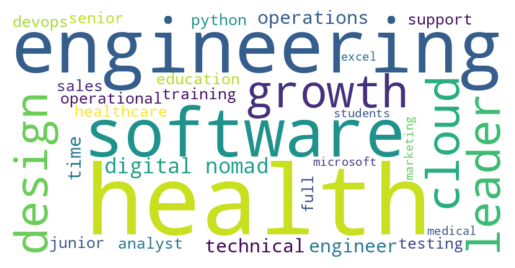

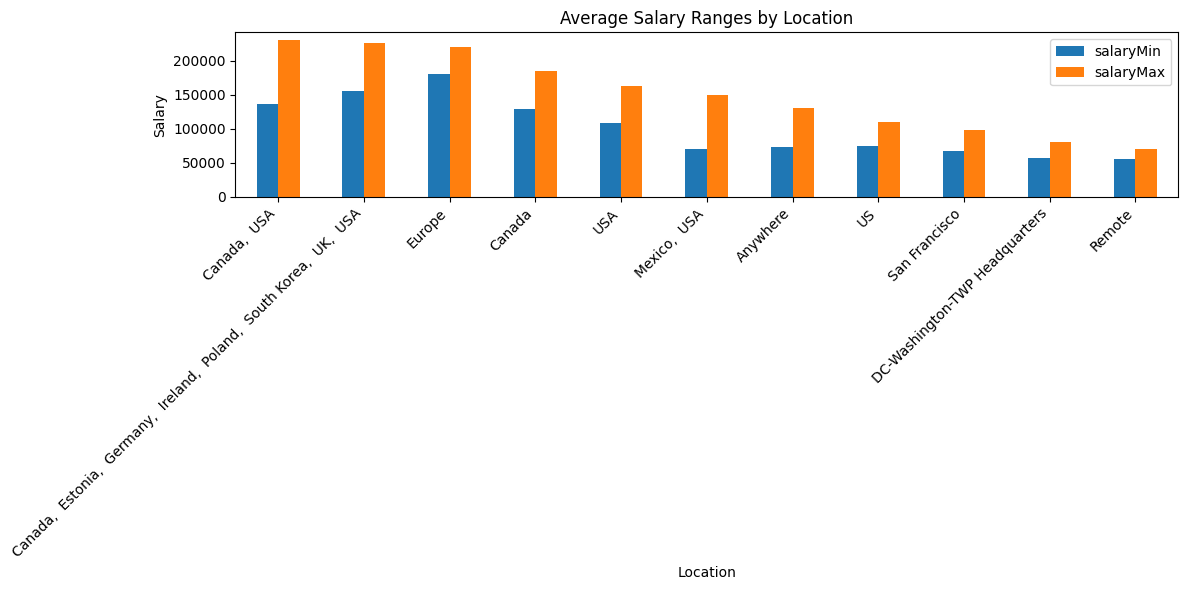

In [2]:
jobs_df = fetch_jobs_from_api(['remoteok', 'jobicy'])
analyze_job_data(jobs_df)

In [ ]:
api_url = "https://jooble.org/api"
keywords = ['analy', 'data', 'machine learning', 'intelligence']

try:
    if JOOBLE_API_KEY is None:
        print("Error: JOOBLE_API_KEY is not set. Please set it in your environment variables.")
    
    # For Jooble, we need to specify the keywords in the URL
    headers = {'Content-Type': 'application/json'}
    body = {'keywords': ''.join(keywords)}
    
    api_url = f"{api_url}/JOOBLE_API_KEY"
    response = requests.post(api_url, timeout=15, headers=headers, data=body)
    response.raise_for_status()
    data = response.json()
    
    if isinstance(data, dict) and len(data) > 0:
        job_list = data.get('jobs', [])
        print(job_list)
    elif isinstance(data, dict) and len(data) == 0:
        print("Jooble found no " + ' '.join(keywords) + "' jobs.")
    else:
        print(f"Unexpected API response format. Expected a dict, got {type(data)}.")
        
except requests.exceptions.ConnectionError:
    print(f"Error: Connection error occurred while trying to reach {api_url}.")
except requests.exceptions.TooManyRedirects:
    print(f"Error: Too many redirects while trying to reach {api_url}.")
except requests.exceptions.Timeout:
    print(f"Error: Request to {api_url} timed out.")
except requests.exceptions.HTTPError as http_err:
    print(f"Error: HTTP error occurred: {http_err} - Status Code: {response.status_code}")
except requests.exceptions.RequestException as req_err:
    print(f"Error: An error occurred while fetching data from API: {req_err}")
except ValueError as json_err:  # Includes json.JSONDecodeError
    print(f"Error: Could not decode JSON response: {json_err}")
    